# In this part, we will build the model for our regression problem.
A class will be used for the storing whole data and models, as well as some functions we have defined.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
import warnings
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses

In [10]:
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

In [17]:
class Regression_models:
    def __init__(self, x_train, y_train, x_test, y_test, standardlise=True):
        self.features_names_list = x_train.columns.tolist()
        self.targert_names_list = y_train.columns.tolist()
        self.x_train, self.x_test, self.y_train, self.y_test = x_train, x_test, y_train, y_test
        if standardlise:
            scaler = StandardScaler()
            self.x_train = scaler.fit_transform(self.x_train)
            self.x_test = scaler.transform(self.x_test)
        if (len(self.targert_names_list) == 1):
            # make target data in np.array
            self.y_train_old = self.y_train
            self.y_test_old = self.y_test
            self.y_train = np.ravel(self.y_train)
            self.y_test = np.ravel(self.y_test)

    def model_metrics(self, y_true=None, y_pred=None, df=None):
        if df is not None:
            y_true = df['true']
            y_pred = df['pred']
        else:
            y_true = y_true
            y_pred = y_pred

        r_sq = r2_score(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        metrics_df = pd.DataFrame({
            'R^2': [r_sq],
            'MSE': [mse],
            'MAE': [mae],
            'MAPE': [mape]
        })
        return metrics_df.T

    def XGBR(
            self,
            searchCV=True,
            best_depth_input=5,
            best_Nestimators=200,
            best_L1_alpha=1,
            show_avsp=True,
            show_features_imp=False):
        if searchCV:
            # params = {'n_estimators': [100], 'max_depth': [12],
            #           'alpha': [0.2]}
            params = {
                'n_estimators': [
                    50, 100, 150, 200], 'max_depth': [
                    6, 8, 10, 12], 'alpha': [
                    0.2, 0.5, 1, 2]}
            # Use GridSearchCV to search over the parameter grid
            grid_search = GridSearchCV(
                XGBRegressor(
                    objective='reg:squarederror'),
                params,
                cv=5,
                scoring='neg_mean_squared_error',
                return_train_score=True,
                verbose=2)
            grid_search.fit(self.x_train, self.y_train)
            best_parameters = grid_search.best_params_
            print('XGBoost Best Parameters:', best_parameters)
            print('XGBoost Best MSE:', -grid_search.best_score_)
        else:
            best_parameters = {
                'n_estimators': best_Nestimators,
                'max_depth': best_depth_input,
                'alpha': best_L1_alpha}

        print('XGBoost Best parameters: ', best_parameters)
        model = XGBRegressor(
            eval_metric='rmse',
            n_estimators=best_parameters['n_estimators'],
            max_depth=best_parameters['max_depth'],
            alpha=best_parameters['alpha'])
        model.fit(
            self.x_train,
            self.y_train)
        train_predictions = model.predict(self.x_train)
        test_predictions = model.predict(self.x_test)
        print('XGBR train R_sq: ', model.score(self.x_train, self.y_train))
        print(
            'XGBR train MSE: ',
            mean_squared_error(
                self.y_train,
                train_predictions))
        print('XGBR test R_sq: ', model.score(self.x_test, self.y_test))
        print(
            'XGBR test MSE: ',
            mean_squared_error(
                self.y_test,
                test_predictions))
        train_info_df = pd.DataFrame(
            {'true': list(self.y_train), 'pred': list(train_predictions)})
        test_info_df = pd.DataFrame(
            {'true': list(self.y_test), 'pred': list(test_predictions)})
        if show_avsp:
            plt.figure(figsize=(18, 6))
            plt.scatter(
                self.y_train,
                train_predictions,
                label='train',
                alpha=0.6,
                c='b')
            plt.scatter(
                self.y_test,
                test_predictions,
                label='test',
                alpha=0.6,
                c='r')
            plt.xlabel('actual')
            plt.ylabel('predictions')
            plt.title('XGBoost')
            plt.legend()
            plt.tight_layout()
            plt.show()
        if show_features_imp:
            plt.figure(figsize=(18, 8))
            sns.barplot(
                y=self.features_names_list,
                x=model.feature_importances_)
            plt.title('feature_importance')
            plt.tight_layout()
            plt.show()
        self.xgb_train_info_df = train_info_df
        self.xgb_test_info_df = test_info_df
        print('\n XGB Metrics train: ')
        print(self.model_metrics(df=train_info_df))
        print('\n XGB Metrics test: ')
        print(self.model_metrics(df=test_info_df))
        return model

    def NN_sequential(
            self,
            loss_func='rmse',
            epoch_num=30,
            bmc_noise_var=160,
            huber_delta=1):
        def r_squared(y_true, y_pred):
            residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
            total = tf.reduce_sum(
                tf.square(
                    tf.subtract(
                        y_true,
                        tf.reduce_mean(y_true))))
            r2 = 1 - tf.divide(residual, total)
            return r2

        def rmse_loss(y_true, y_pred):
            return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

        def bmc_loss(y_true, y_pred):
            """Compute the Balanced MSE Loss (BMC) between `pred` and the ground truth `targets`.
            Args:
              y_pred: A float tensor of size [batch, 1].
              y_true: A float tensor of size [batch, 1].
            Returns:
              loss: A float tensor. Balanced MSE Loss.
            """
            # Calculate the mean
            var_helper = tf.reduce_mean(
                tf.square(y_true - tf.reduce_mean(y_true)))
            # noise_var = tf.divide(var_helper, tf.cast(tf.size(y_true) - 1, dtype=tf.float32))
            noise_var = bmc_noise_var
            logits = -tf.divide(tf.pow(y_pred - tf.transpose(y_true), 2), (2 * noise_var))
            labels = tf.range(tf.shape(y_pred)[0])
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=labels)
            loss = loss * (2 * noise_var)
            return loss

        def huber_loss(y_true, y_pred):
            y_true = tf.cast(y_true, dtype=tf.float32)
            huber_delta1 = tf.cast(huber_delta, dtype=tf.float32)
            residual = tf.abs(y_true - y_pred)
            condition = tf.less(residual, huber_delta1)
            small_res = 0.5 * tf.square(residual)
            large_res = huber_delta1 * residual - 0.5 * tf.square(huber_delta1)
            loss = tf.where(condition, small_res, large_res)
            return tf.reduce_mean(loss)

        if loss_func == 'rmse':
            loss_fun = rmse_loss
        elif loss_func == 'bmc':
            loss_fun = bmc_loss
        elif loss_func == 'mape':
            loss_fun = losses.mean_absolute_percentage_error
        elif loss_func == 'huber':
            loss_fun = huber_loss
        else:
            loss_fun = 'mse'
        NN_model = tf.keras.Sequential()
        NN_model.add(
            layers.Dense(
                200,
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
        NN_model.add(
            layers.Dense(
                400,
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
        NN_model.add(
            layers.Dense(
                200,
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
        NN_model.add(
            layers.Dense(
                100,
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
        NN_model.add(layers.Dense(1, activation='relu'))
        NN_model.compile(optimizer='adam', loss=loss_fun, metrics=[r_squared])
        History = NN_model.fit(self.x_train, self.y_train, epochs=epoch_num,
                               verbose=True, batch_size=300)
        # print(History.history)
        y_predict_tr = NN_model.predict(self.x_train)
        r_sq_tr = r2_score(self.y_train, y_predict_tr)
        mse_tr = mean_squared_error(self.y_train, y_predict_tr)
        print('NN train R_square: ', r_sq_tr)
        print('NN train MSE: ', mse_tr)

        y_predict = NN_model.predict(self.x_test)
        r_sq = r2_score(self.y_test, y_predict)
        mse_te = mean_squared_error(self.y_test, y_predict)
        print('NN test R_square: ', r_sq)
        print('NN test MSE: ', mse_te)
        train_info_df = pd.DataFrame(
            {'true': list(self.y_train), 'pred': list(y_predict_tr)})
        test_info_df = pd.DataFrame(
            {'true': list(self.y_test), 'pred': list(y_predict)})
        self.nn_train_info_df = train_info_df
        self.nn_test_info_df = test_info_df
        print('\n NN Metrics train: ')
        print(self.model_metrics(df=train_info_df))
        print('\n NN Metrics test: ')
        print(self.model_metrics(df=test_info_df))
        return NN_model

    def isOutlier(self, true, pred, threshold_pct):
        # Modified Z-score
        mse = np.median(np.power(true - pred, 2), axis=1)
        threshold = np.percentile(mse, threshold_pct)
        # return index where mse>threshold
        outliers_array = np.where(mse > threshold)[0]
        return outliers_array

    def label_outliers_zscore(self, col):
        # Find all non-outlier data
        z_scores = np.abs((col - col.mean()) / col.std())
        return np.where(
            np.array([1 if z > 3 else 0 for z in z_scores]) == 0)[0]

    def do_auto_encoder(self, train_normal_data, encoding_dim):
        input_dim = self.x_train.shape[1]
        input_layer = layers.Input(shape=(input_dim,))
        encoder = layers.Dense(
            encoding_dim,
            activation="tanh",
            activity_regularizer=regularizers.l1(10e-5))(input_layer)
        encoder = layers.Dense(int(encoding_dim / 2),
                               activation="relu")(encoder)
        decoder = layers.Dense(int(encoding_dim / 2),
                               activation='tanh')(encoder)
        decoder = layers.Dense(input_dim, activation='relu')(decoder)
        autoencoder = tf.keras.models.Model(
            inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        autoencoder.fit(
            train_normal_data,
            train_normal_data,
            epochs=50,
            batch_size=32,
            shuffle=True,
            verbose=1)
        train_predictions = autoencoder.predict(self.x_train)
        test_predictions = autoencoder.predict(self.x_test)
        train_outliers = self.isOutlier(self.x_train, train_predictions, 99)
        test_outliers = self.isOutlier(self.x_test, test_predictions, 99)
        mask1 = np.ones(len(self.x_train), dtype=bool)
        mask1[train_outliers] = False
        mask2 = np.ones(len(self.x_test), dtype=bool)
        mask2[test_outliers] = False
        self.x_train_aec = self.x_train[mask1]
        self.x_test_aec = self.x_test[mask2]
        self.y_train_aec = np.ravel(
            self.y_train_old.drop(
                train_outliers, axis=0))
        self.y_test_aec = np.ravel(self.y_test_old.drop(test_outliers, axis=0))
        self.x_train_aec2 = self.x_train[train_outliers]
        self.x_test_aec2 = self.x_test[test_outliers]
        self.y_train_aec2 = self.y_train[train_outliers]
        self.y_test_aec2 = self.y_test[test_outliers]

    def autoencoder_with_xgboost(
            self,
            best_parameters_normal,
            best_parameters_abnormal,
            encoding_dim=64,
            searchCV_ab=False):
        helper_index = self.label_outliers_zscore(
            self.y_train_old[self.y_train_old.columns[0]])
        x_train_normal = self.x_train[helper_index]
        self.do_auto_encoder(x_train_normal, encoding_dim=encoding_dim)
        xgb_normal = XGBRegressor(
            eval_metric='rmse',
            n_estimators=best_parameters_normal['n_estimators'],
            max_depth=best_parameters_normal['max_depth'],
            alpha=best_parameters_normal['alpha'])
        xgb_normal.fit(self.x_train_aec, self.y_train_aec)
        train_predictions = xgb_normal.predict(self.x_train_aec)
        test_predictions = xgb_normal.predict(self.x_test_aec)
        train_info_df_normal = pd.DataFrame(
            {'true': list(self.y_train_aec), 'pred': list(train_predictions)})
        test_info_df_normal = pd.DataFrame(
            {'true': list(self.y_test_aec), 'pred': list(test_predictions)})
        if searchCV_ab:
            params = {'n_estimators': [20, 50, 100], 'max_depth': [4, 6, 8],
                      'alpha': [0.5, 1, 2, 5]}
            # Use GridSearchCV to search over the parameter grid
            grid_search = GridSearchCV(
                XGBRegressor(
                    objective='reg:squarederror'),
                params,
                cv=3,
                scoring='neg_mean_squared_error',
                return_train_score=True,
                verbose=1)
            grid_search.fit(self.x_train_aec2, self.y_train_aec2)
            best_parameters_abnormal = grid_search.best_params_
        else:
            best_parameters_abnormal = best_parameters_abnormal

        xgb_abnormal = XGBRegressor(
            eval_metric='rmse',
            n_estimators=best_parameters_abnormal['n_estimators'],
            max_depth=best_parameters_abnormal['max_depth'],
            alpha=best_parameters_abnormal['alpha'])
        xgb_abnormal.fit(self.x_train_aec2, self.y_train_aec2)
        train_predictions2 = xgb_abnormal.predict(self.x_train_aec2)
        test_predictions2 = xgb_abnormal.predict(self.x_test_aec2)
        train_info_df_abnormal = pd.DataFrame(
            {'true': list(self.y_train_aec2), 'pred': list(train_predictions2)})
        test_info_df_abnormal = pd.DataFrame(
            {'true': list(self.y_test_aec2), 'pred': list(test_predictions2)})
        all_train_info = pd.concat(
            [train_info_df_normal, train_info_df_abnormal], axis=0)
        all_test_info = pd.concat(
            [test_info_df_normal, test_info_df_abnormal], axis=0)
        r_sq_tr = r2_score(all_train_info['true'], all_train_info['pred'])
        mse_tr = mean_squared_error(
            all_train_info['true'],
            all_train_info['pred'])
        print('Autoencoder+XGB train R_square: ', r_sq_tr)
        print('Autoencoder+XGB train MSE: ', mse_tr)
        r_sq_te = r2_score(all_test_info['true'], all_test_info['pred'])
        mse_te = mean_squared_error(
            all_test_info['true'],
            all_test_info['pred'])
        print('Autoencoder+XGB test R_square: ', r_sq_te)
        print('Autoencoder+XGB test MSE: ', mse_te)
        print('\n Autoencoder+XGB Metrics train: ')
        print(self.model_metrics(df=all_train_info))
        print('\n Autoencoder+XGB Metrics test: ')
        print(self.model_metrics(df=all_test_info))

    def XGBoost_with_NN(
            self,
            searchCV=False,
            best_depth_input=10,
            best_Nestimators=200,
            best_L1_alpha=1,
            show_avsp=True,
            show_features_imp=False,
            epochs=100):
        xgb_model = self.XGBR(
            searchCV=searchCV,
            best_depth_input=best_depth_input,
            best_Nestimators=best_Nestimators,
            best_L1_alpha=best_L1_alpha,
            show_avsp=show_avsp,
            show_features_imp=show_features_imp)
        train_info = self.xgb_train_info_df
        test_info = self.xgb_test_info_df
        train_residuals = np.array(train_info['true'] - train_info['pred'])
        # Train a neural network model on the residuals of the train set
        input_layer = layers.Input(shape=(self.x_train.shape[1],))
        NN_model = tf.keras.Sequential()
        NN_model.add(
            layers.Dense(
                100,
                activation='tanh',
                kernel_regularizer=regularizers.l2(0.01)))
        NN_model.add(
            layers.Dense(
                200,
                activation='tanh',
                kernel_regularizer=regularizers.l2(0.01)))
        NN_model.add(
            layers.Dense(
                100,
                activation='tanh',
                kernel_regularizer=regularizers.l2(0.01)))
        NN_model.add(layers.Dense(1, activation='linear'))
        NN_model.compile(
            loss=losses.mean_squared_logarithmic_error,
            optimizer="adam")
        NN_model.fit(
            self.x_train,
            train_residuals,
            epochs=epochs,
            batch_size=300,
            verbose=2)
        NN_model_preds_tr = NN_model.predict(self.x_train)
        overall_preds_tr = np.array(
            train_info['pred']) + NN_model_preds_tr.flatten()
        metrics_df_tr = self.model_metrics(
            self.y_train, overall_preds_tr, df=None)
        print('XGBoost+NN train: ')
        print(metrics_df_tr)
        print('\n')
        NN_model_preds = NN_model.predict(self.x_test)
        overall_preds = np.array(test_info['pred']) + NN_model_preds.flatten()
        metrics_df = self.model_metrics(self.y_test, overall_preds, df=None)
        print('XGBoost+NN test: ')
        print(metrics_df)

In [18]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
train_df = train_df.drop('baseFare', axis=1)
test_df = test_df.drop('baseFare', axis=1)
y_train = train_df[['totalFare']]
x_train = train_df.drop('totalFare', axis=1)
y_test = test_df[['totalFare']]
x_test = test_df.drop('totalFare', axis=1)

In [19]:
Reg_models = Regression_models(x_train, y_train, x_test, y_test, standardlise=True)

## Linear Regression

The Shapiro-Wilk test is a hypothesis test that assesses whether a sample comes from a normal distribution. In this case, we apply the Shapiro-Wilk test to the residuals of the model to check the normality assumption of linear regression. The p-value is a measure of the evidence against the null hypothesis, which is that the residuals are normally distributed. A p-value less than the significance level (e.g., 0.05) suggests that we have sufficient evidence to reject the null hypothesis and conclude that the residuals are not normally distributed. Conversely, a p-value greater than the significance level suggests that we do not have sufficient evidence to reject the null hypothesis and that the residuals are likely normally distributed.

## XGBoost Models

Noticed that we need set searchCV=True to use cross-validation to do the hyperparemeter tuning, in order to see result directly, we won't show the details, but we set the best hyperparamenters here. For details, please check the full version, find README file.

* Fitting 5 folds for each of 64 candidates, totalling 320 fits, around total 3200s
* Outputs:
XGBoost Best parameters:  {'alpha': 0.2, 'max_depth': 10, 'n_estimators': 150}

XGBoost Best parameters:  {'n_estimators': 150, 'max_depth': 10, 'alpha': 0.2}
XGBR train R_sq:  0.9706137689548603
XGBR train MSE:  862.3551819540154
XGBR test R_sq:  0.870464138753656
XGBR test MSE:  4139.450574701229


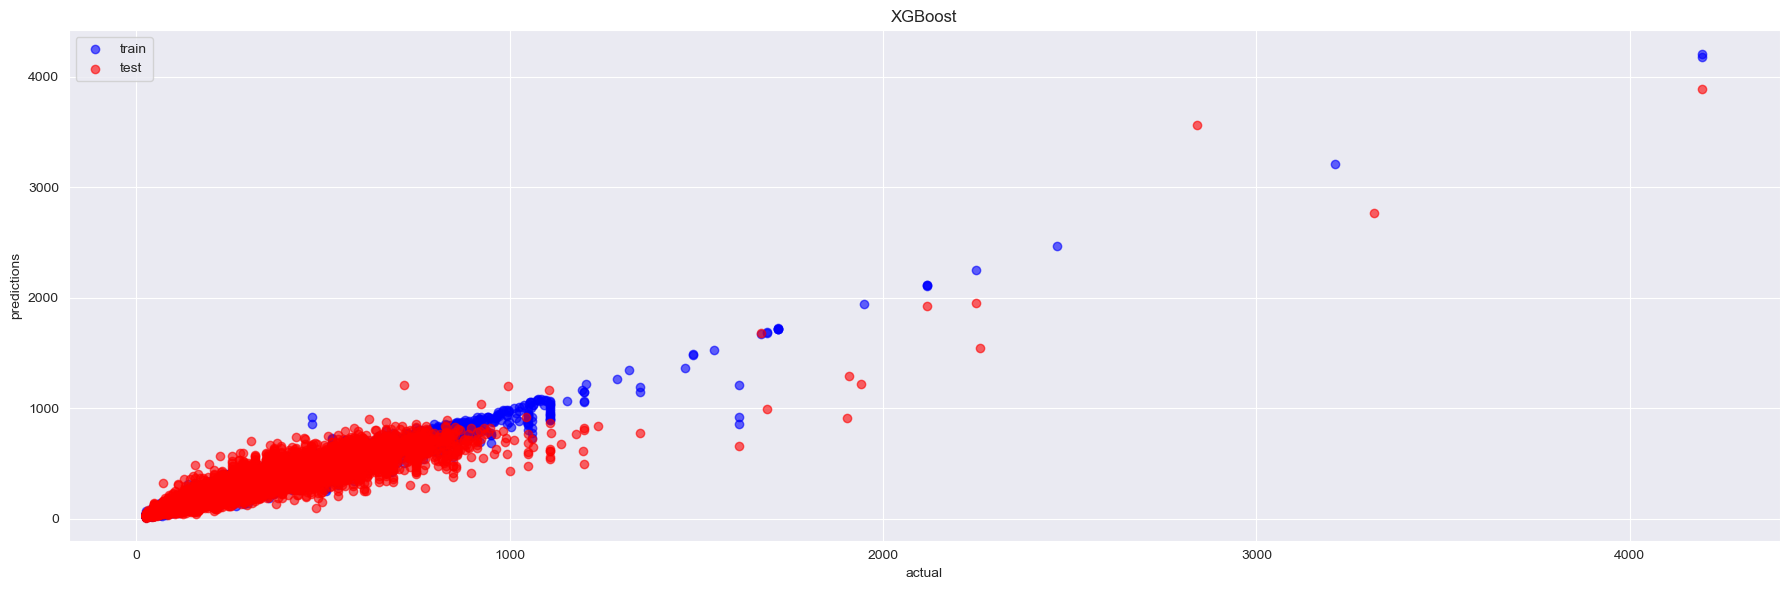

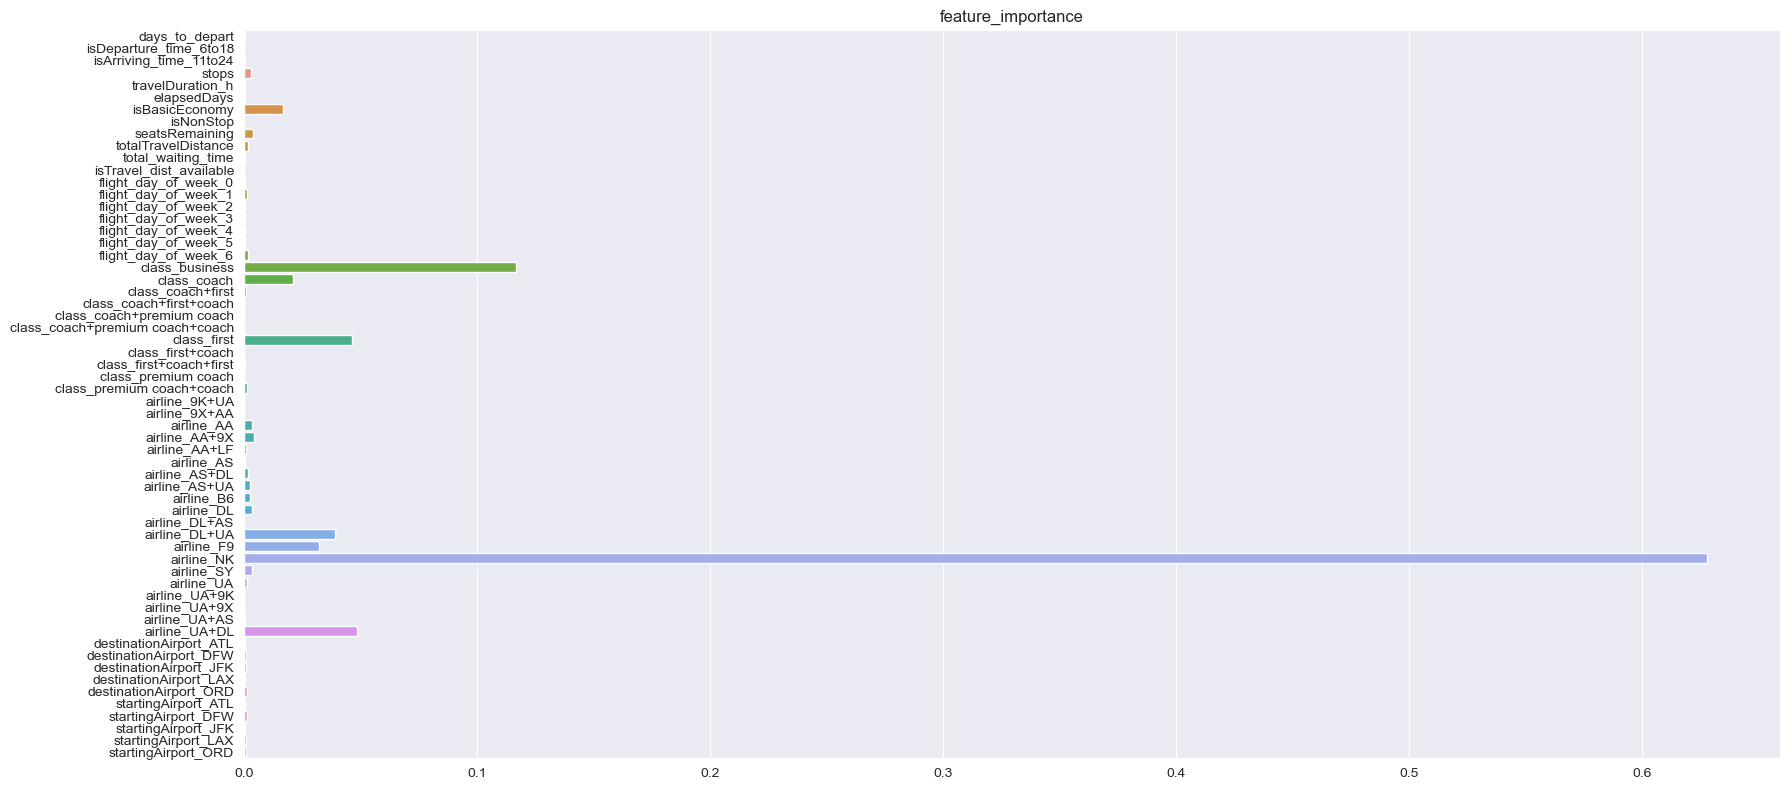


 XGB Metrics train: 
               0
R^2     0.970614
MSE   862.355182
MAE    19.814945
MAPE    0.081044

 XGB Metrics test: 
                0
R^2      0.870464
MSE   4139.450575
MAE     40.555511
MAPE     0.149833


In [20]:
xgb_model = Reg_models.XGBR(searchCV=False, best_depth_input=10, best_Nestimators=150,
                            best_L1_alpha=0.2, show_avsp=True, show_features_imp=True)

In [21]:
xgb_features_imp_df = pd.DataFrame(data={'features': np.array(Reg_models.features_names_list),
                                         'importance': xgb_model.feature_importances_}).sort_values('importance',
                                                                                                    ascending=False)
xgb_features_imp_df

,features,importance
43,airline_NK,0.628017
19,class_business,0.116601
49,airline_UA+DL,0.048539
25,class_first,0.046244
41,airline_DL+UA,0.039132
42,airline_F9,0.032033
20,class_coach,0.021231
6,isBasicEconomy,0.016932
33,airline_AA+9X,0.004275
8,seatsRemaining,0.003742


Here is the xgb_model without L1 regularisation. Use to compare.

In [22]:
xgb_model_no_L1 = Reg_models.XGBR(searchCV=False, best_depth_input=10, best_Nestimators=150, best_L1_alpha=0,
                                  show_avsp=False, show_features_imp=False)

XGBoost Best parameters:  {'n_estimators': 150, 'max_depth': 10, 'alpha': 0}
XGBR train R_sq:  0.9726221066303179
XGBR train MSE:  803.419403531665
XGBR test R_sq:  0.8698832513765595
XGBR test MSE:  4158.013423350423

 XGB Metrics train: 
               0
R^2     0.972622
MSE   803.419404
MAE    19.211173
MAPE    0.078630

 XGB Metrics test: 
                0
R^2      0.869883
MSE   4158.013423
MAE     40.459200
MAPE     0.149786


#### Drop non-important features?

We shall also reconsider the features engineering based on the importance of XGBoost and EDA

## Neural Networks

In [24]:
seq_NN_rmse = Reg_models.NN_sequential(epoch_num=100, loss_func='rmse')

Epoch 1/100
237/237 [==============================] - 2s 5ms/step - loss: 190.4809 - r_squared: -0.4993
Epoch 2/100
237/237 [==============================] - 1s 6ms/step - loss: 87.6229 - r_squared: 0.7608
Epoch 3/100
237/237 [==============================] - 1s 5ms/step - loss: 84.8944 - r_squared: 0.7745
Epoch 4/100
237/237 [==============================] - 3s 11ms/step - loss: 82.9628 - r_squared: 0.7817
Epoch 5/100
237/237 [==============================] - 1s 5ms/step - loss: 82.1825 - r_squared: 0.7831
Epoch 6/100
237/237 [==============================] - 1s 5ms/step - loss: 83.0384 - r_squared: 0.7801
Epoch 7/100
237/237 [==============================] - 1s 5ms/step - loss: 82.7779 - r_squared: 0.7860
Epoch 8/100
237/237 [==============================] - 1s 5ms/step - loss: 79.0418 - r_squared: 0.7988
Epoch 9/100
237/237 [==============================] - 1s 5ms/step - loss: 79.2032 - r_squared: 0.7935
Epoch 10/100
237/237 [==============================] - 1s 5ms/step - 

In [25]:
seq_NN_with_Bmse = Reg_models.NN_sequential(epoch_num=100, loss_func='bmc', bmc_noise_var=220)

Epoch 1/100
237/237 [==============================] - 2s 6ms/step - loss: 44102.2046 - r_squared: -0.6129
Epoch 2/100
237/237 [==============================] - 1s 6ms/step - loss: 8259.1281 - r_squared: 0.7437
Epoch 3/100
237/237 [==============================] - 1s 6ms/step - loss: 7733.0661 - r_squared: 0.7676
Epoch 4/100
237/237 [==============================] - 1s 6ms/step - loss: 7445.6355 - r_squared: 0.7826
Epoch 5/100
237/237 [==============================] - 2s 6ms/step - loss: 7388.6661 - r_squared: 0.7862
Epoch 6/100
237/237 [==============================] - 2s 7ms/step - loss: 7021.8234 - r_squared: 0.7938
Epoch 7/100
237/237 [==============================] - 1s 6ms/step - loss: 6920.4874 - r_squared: 0.7949
Epoch 8/100
237/237 [==============================] - 1s 6ms/step - loss: 6902.9908 - r_squared: 0.8011
Epoch 9/100
237/237 [==============================] - 1s 6ms/step - loss: 6729.5617 - r_squared: 0.8095
Epoch 10/100
237/237 [==============================]

In [23]:
seq_NN_with_mape = Reg_models.NN_sequential(epoch_num=100, loss_func='mape')

2023-04-21 22:28:23.309351: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-21 22:28:23.311788: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 22:28:23.395122: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
237/237 [==============================] - 2s 5ms/step - loss: 55.8585 - r_squared: -0.6914
Epoch 2/100
237/237 [==============================] - 1s 5ms/step - loss: 22.1594 - r_squared: 0.7161
Epoch 3/100
237/237 [==============================] - 1s 5ms/step - loss: 20.6456 - r_squared: 0.7249
Epoch 4/100
237/237 [==============================] - 1s 5ms/step - loss: 19.8460 - r_squared: 0.7306
Epoch 5/100
237/237 [==============================] - 1s 5ms/step - loss: 19.4826 - r_squared: 0.7287
Epoch 6/100
237/237 [==============================] - 1s 5ms/step - loss: 18.9651 - r_squared: 0.7384
Epoch 7/100
237/237 [==============================] - 1s 5ms/step - loss: 18.9672 - r_squared: 0.7385
Epoch 8/100
237/237 [==============================] - 1s 5ms/step - loss: 18.7756 - r_squared: 0.7344
Epoch 9/100
237/237 [==============================] - 1s 6ms/step - loss: 18.5221 - r_squared: 0.7395
Epoch 10/100
237/237 [==============================] - 1s 6ms/step - lo

#### Using MAPE may cause some problems

When you change your loss function from Mean Squared Error (MSE) to Mean Absolute Percentage Error (MAPE), you are changing the way your model learns from the training data. MSE is a popular loss function for regression problems, and it penalizes the model more for large errors. MAPE, on the other hand, penalizes the model more for large errors relative to the true value.

It is possible that changing the loss function from MSE to MAPE is causing your R-squared value to decrease. One possible reason is that MAPE may not be as sensitive to small changes in the predictions as MSE. As a result, your model may not be penalized enough for small errors in the predictions, leading to a lower R-squared value.

Another reason could be that MAPE is a relative error metric, and it may not be suitable for all types of data. For example, if your data contains many zero values, MAPE may not be an appropriate loss function as it can result in infinite or undefined values.

In [26]:
seq_NN_with_huber = Reg_models.NN_sequential(epoch_num=100, loss_func='huber', huber_delta=1)

Epoch 1/100
237/237 [==============================] - 2s 5ms/step - loss: 149.4456 - r_squared: -0.5677
Epoch 2/100
237/237 [==============================] - 1s 5ms/step - loss: 59.3941 - r_squared: 0.7536
Epoch 3/100
237/237 [==============================] - 1s 5ms/step - loss: 57.2283 - r_squared: 0.7625
Epoch 4/100
237/237 [==============================] - 1s 5ms/step - loss: 55.8041 - r_squared: 0.7736
Epoch 5/100
237/237 [==============================] - 1s 5ms/step - loss: 55.0349 - r_squared: 0.7705
Epoch 6/100
237/237 [==============================] - 1s 5ms/step - loss: 54.3596 - r_squared: 0.7796
Epoch 7/100
237/237 [==============================] - 1s 5ms/step - loss: 53.3048 - r_squared: 0.7855
Epoch 8/100
237/237 [==============================] - 1s 5ms/step - loss: 52.8889 - r_squared: 0.7846
Epoch 9/100
237/237 [==============================] - 1s 5ms/step - loss: 52.3431 - r_squared: 0.7885
Epoch 10/100
237/237 [==============================] - 1s 5ms/step - l

## Autoencoder with XGBoost
We perform cross-validation to search hyperparameters for normal and abnormal data.

In [32]:
Reg_models.autoencoder_with_xgboost(best_parameters_normal={'n_estimators': 200, 'max_depth': 8, 'alpha': 1},
                                    best_parameters_abnormal={'n_estimators': 50, 'max_depth': 4, 'alpha': 2},
                                    searchCV_ab=True)


Epoch 1/50
2206/2206 [==============================] - 1s 569us/step - loss: 0.5748
Epoch 2/50
2206/2206 [==============================] - 1s 566us/step - loss: 0.4220
Epoch 3/50
2206/2206 [==============================] - 1s 566us/step - loss: 0.3687
Epoch 4/50
2206/2206 [==============================] - 1s 556us/step - loss: 0.3609
Epoch 5/50
2206/2206 [==============================] - 1s 553us/step - loss: 0.3393
Epoch 6/50
2206/2206 [==============================] - 1s 550us/step - loss: 0.3248
Epoch 7/50
2206/2206 [==============================] - 1s 555us/step - loss: 0.3413
Epoch 8/50
2206/2206 [==============================] - 1s 551us/step - loss: 0.3271
Epoch 9/50
2206/2206 [==============================] - 1s 555us/step - loss: 0.3533
Epoch 10/50
2206/2206 [==============================] - 1s 548us/step - loss: 0.3532
Epoch 11/50
2206/2206 [==============================] - 1s 546us/step - loss: 0.3312
Epoch 12/50
2206/2206 [==============================] - 1s 551

## XGBoost with NN
We continue to ues the hyperparameters we got in XGBoost for the same data input.

In [29]:
Reg_models.XGBoost_with_NN(searchCV=False, best_depth_input=10, best_Nestimators=150, best_L1_alpha=0.2,
                           show_avsp=False, show_features_imp=False, epochs=100)

XGBoost Best parameters:  {'n_estimators': 150, 'max_depth': 10, 'alpha': 0.2}
XGBR train R_sq:  0.9706137689548603
XGBR train MSE:  862.3551819540154
XGBR test R_sq:  0.870464138753656
XGBR test MSE:  4139.450574701229

 XGB Metrics train: 
               0
R^2     0.970614
MSE   862.355182
MAE    19.814945
MAPE    0.081044

 XGB Metrics test: 
                0
R^2      0.870464
MSE   4139.450575
MAE     40.555511
MAPE     0.149833
Epoch 1/100
237/237 - 1s - loss: 3.5568
Epoch 2/100
237/237 - 0s - loss: 2.2850
Epoch 3/100
237/237 - 0s - loss: 2.2023
Epoch 4/100
237/237 - 0s - loss: 2.1915
Epoch 5/100
237/237 - 1s - loss: 2.1872
Epoch 6/100
237/237 - 0s - loss: 2.1860
Epoch 7/100
237/237 - 0s - loss: 2.1863
Epoch 8/100
237/237 - 0s - loss: 2.1846
Epoch 9/100
237/237 - 0s - loss: 2.1850
Epoch 10/100
237/237 - 0s - loss: 2.1849
Epoch 11/100
237/237 - 0s - loss: 2.1849
Epoch 12/100
237/237 - 0s - loss: 2.1837
Epoch 13/100
237/237 - 0s - loss: 2.1836
Epoch 14/100
237/237 - 0s - loss: 2.18